In [1]:
# Learning tensorflow data

In [2]:
import numpy as np
import pandas as pd
from itertools import combinations 
import tensorflow as tf
from tensorflow.keras.layers import Input, Flatten, Dense, Activation, Lambda, Reshape
from tensorflow.keras.models import Model
import tensorflow.keras.backend as K
import tensorflow_addons as tfa

In [3]:
# Create dummy data
array_a = np.array([[0, 1], [2, 3], [4, 5], [6, 7], [8, 9]])
array_b = np.array([-1, -2, -3, -4, -5])
print(array_a)
print(array_b)

[[0 1]
 [2 3]
 [4 5]
 [6 7]
 [8 9]]
[-1 -2 -3 -4 -5]


In [4]:
# Dataset functions
for m in dir(tf.data.Dataset):
    if not (m.startswith("_") or m.endswith("_")):
        func = getattr(tf.data.Dataset, m)
        if hasattr(func, "__doc__"):
            print("● {:21s}{}".format(m + "()", func.__doc__.split("\n")[0]))

● apply()              Applies a transformation function to this dataset.
● as_numpy_iterator()  Returns an iterator which converts all elements of the dataset to numpy.
● batch()              Combines consecutive elements of this dataset into batches.
● cache()              Caches the elements in this dataset.
● concatenate()        Creates a `Dataset` by concatenating the given dataset with this dataset.
● element_spec()       The type specification of an element of this dataset.
● enumerate()          Enumerates the elements of this dataset.
● filter()             Filters this dataset according to `predicate`.
● flat_map()           Maps `map_func` across this dataset and flattens the result.
● from_generator()     Creates a `Dataset` whose elements are generated by `generator`.
● from_tensor_slices() Creates a `Dataset` whose elements are slices of the given tensors.
● from_tensors()       Creates a `Dataset` with a single element, comprising the given tensors.
● interleave()      

In [5]:
# Define tensorflow dataset
dataset = tf.data.Dataset.from_tensor_slices((array_a, array_b))
for a,b in dataset:
    print(a.numpy(), ' , ', b.numpy())

[0 1]  ,  -1
[2 3]  ,  -2
[4 5]  ,  -3
[6 7]  ,  -4
[8 9]  ,  -5


In [6]:
# Concatenate datasets
dataset0 = tf.data.Dataset.from_tensor_slices(array_b)
dataset1 = tf.data.Dataset.from_tensor_slices(array_b)
dataset_concat = dataset0.concatenate(dataset1)
for a in dataset_concat:
    print(a.numpy())

-1
-2
-3
-4
-5
-1
-2
-3
-4
-5


In [7]:
# Filtering
dataset_singles = tf.data.Dataset.from_tensor_slices(array_b)
filtered = dataset_singles.filter(lambda x: x < -3)
for a in filtered:
    print(a.numpy())

print()
dataset_arrays = tf.data.Dataset.from_tensor_slices(array_a)
filtered = dataset_arrays.filter(lambda x: x[0] > 5)
for a in filtered:
    print(a.numpy())
    
print()
filtered = dataset.filter(lambda x,y: y < -3)
for a,b in filtered:
    print(a.numpy(), ' , ', b.numpy())
    
print()
def filter_function(x,y):
    decision = y < -3
    return decision
filtered = dataset.filter(filter_function)
for a,b in filtered:
    print(a.numpy(), ' , ', b.numpy())

-4
-5

[6 7]
[8 9]

[6 7]  ,  -4
[8 9]  ,  -5

[6 7]  ,  -4
[8 9]  ,  -5


In [8]:
# Preprocessing: Apply Python functions
def tf_some_python_function(input_a, input_b):
    [input_a,] = tf.py_function(np.log1p, [input_a], [tf.float32])
    return input_a, input_b

mapped_dataset = dataset.map(tf_some_python_function,
                             num_parallel_calls=3)

for a,b in mapped_dataset:
    print(a.numpy(), ' , ', b.numpy())

[0.        0.6931472]  ,  -1
[1.0986123 1.3862944]  ,  -2
[1.609438  1.7917595]  ,  -3
[1.9459101 2.0794415]  ,  -4
[2.1972246 2.3025851]  ,  -5


In [9]:
# Batches
batch_size = 2
take_n_batch = 5

print('\nBatched data, keep partial:')            
batched_dataset = dataset.batch(batch_size, drop_remainder=False)

for i, batch in enumerate(batched_dataset.take(take_n_batch)):
    print('batch', i)
    for arr in batch:
        print(arr.numpy())
        
print('\nBatched data, keep partial, repeat:')            
batched_dataset = dataset.batch(batch_size, drop_remainder=False)
batched_dataset = batched_dataset.repeat()

for i, batch in enumerate(batched_dataset.take(take_n_batch)):
    print('batch', i)
    for arr in batch:
        print(arr.numpy())


Batched data, keep partial:
batch 0
[[0 1]
 [2 3]]
[-1 -2]
batch 1
[[4 5]
 [6 7]]
[-3 -4]
batch 2
[[8 9]]
[-5]

Batched data, keep partial, repeat:
batch 0
[[0 1]
 [2 3]]
[-1 -2]
batch 1
[[4 5]
 [6 7]]
[-3 -4]
batch 2
[[8 9]]
[-5]
batch 3
[[0 1]
 [2 3]]
[-1 -2]
batch 4
[[4 5]
 [6 7]]
[-3 -4]


In [10]:
# Shuffle
# shuffle, batch, repeat order should be kept
shuffled = dataset.shuffle(buffer_size=100)
shuffled = shuffled.batch(batch_size)
shuffled = shuffled.repeat()
for i, batch in enumerate(shuffled.take(take_n_batch)):
    print('batch', i)
    for arr in batch:
        print(arr.numpy())

batch 0
[[8 9]
 [6 7]]
[-5 -4]
batch 1
[[0 1]
 [2 3]]
[-1 -2]
batch 2
[[4 5]]
[-3]
batch 3
[[0 1]
 [2 3]]
[-1 -2]
batch 4
[[4 5]
 [6 7]]
[-3 -4]


In [11]:
# Prefetch
# Most dataset input pipelines should end with a call to prefetch.
# This allows later elements to be prepared while the current element is being processed.
# This often improves latency and throughput, at the cost of using additional memory to store prefetched elements.

prefetched = dataset
prefetched = prefetched.batch(batch_size)
prefetched = prefetched.repeat()
prefetched = prefetched.prefetch(buffer_size=500)

for i, batch in enumerate(prefetched.take(take_n_batch)):
    print('batch', i)
    for arr in batch:
        print(arr.numpy())

batch 0
[[0 1]
 [2 3]]
[-1 -2]
batch 1
[[4 5]
 [6 7]]
[-3 -4]
batch 2
[[8 9]]
[-5]
batch 3
[[0 1]
 [2 3]]
[-1 -2]
batch 4
[[4 5]
 [6 7]]
[-3 -4]


In [12]:
# Timeseries forecasting (one timeseries)

In [13]:
# Define timeseries
timeseries = tf.data.Dataset.range(100000)

In [14]:
# Simple rolling window
batches = timeseries.batch(10, drop_remainder=True)

print('Rolling window:')
for i, example in enumerate(batches.take(3)):
    print('window', i, ':', example.numpy())

Rolling window:
window 0 : [0 1 2 3 4 5 6 7 8 9]
window 1 : [10 11 12 13 14 15 16 17 18 19]
window 2 : [20 21 22 23 24 25 26 27 28 29]


In [15]:
# Rolling window, window = feature data + data to be predicted
def label_next_5_steps(batch):
    return (batch[:-5], batch[-5:])

inputs_and_labels = batches.map(label_next_5_steps)

print('Split rolling window into input features and labels(predicted features):')
for input_feature, label in inputs_and_labels.take(3):
    print(input_feature.numpy(), " => ", label.numpy())

Split rolling window into input features and labels(predicted features):
[0 1 2 3 4]  =>  [5 6 7 8 9]
[10 11 12 13 14]  =>  [15 16 17 18 19]
[20 21 22 23 24]  =>  [25 26 27 28 29]


In [16]:
# Rolling window generalized
# Create dataset of windows out of timeseries dataset
input_feature_steps = 5
predict_steps = 3
stride = 3
shift = 2
window_size = input_feature_steps + predict_steps
windows = timeseries.window(size=window_size,
                            shift=shift,
                            stride=stride)

# Batchify then flatten the dataset of batches into a dataset of their elements
windows = windows.flat_map(lambda x: x.batch(window_size, drop_remainder=True))

print('Rolling window:')
for i, example in enumerate(windows.take(3)):
    print('window', i, ':', example.numpy())

# Split rolling window into input features and labels(predicted features)
def split_at_n(batch, n):
    return batch[:-n], batch[-n:]

inputs_and_labels = windows.map(lambda x: split_at_n(x, n=predict_steps))
# .prefetch(x) for faster pipeline

print()
print('Split rolling window into input features and labels(predicted features):')
for input_feature, label in inputs_and_labels.take(3):
    print(input_feature.numpy(), "=>", label.numpy())


Rolling window:
window 0 : [ 0  3  6  9 12 15 18 21]
window 1 : [ 2  5  8 11 14 17 20 23]
window 2 : [ 4  7 10 13 16 19 22 25]

Split rolling window into input features and labels(predicted features):
[ 0  3  6  9 12] => [15 18 21]
[ 2  5  8 11 14] => [17 20 23]
[ 4  7 10 13 16] => [19 22 25]


In [17]:
# Generator in 'real' action

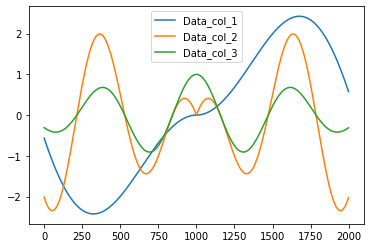

In [18]:
# Generating data and labels
def dummy_function(x):
    a = 0.4 * np.sin(0.3 * x) * np.abs(x)
    b = np.log1p(np.abs(x)) * np.cos(x)
    c = np.exp(-x**2 / 100) * np.cos(x)
    return [a, b, c]

x = np.arange(-10, 10, 0.01)
df = pd.DataFrame(np.array([dummy_function(xi) for xi in x]), columns=['Data_col_1', 'Data_col_2', 'Data_col_3'])

df[['Data_col_1', 'Data_col_2', 'Data_col_3']].plot()

In [19]:
# Rolling window generalized
# Create timeseries dataset
timeseries = tf.data.Dataset.from_tensor_slices(df[['Data_col_1', 'Data_col_2', 'Data_col_3']].values)

# Create dataset of windows out of timeseries dataset
input_feature_steps = 3
predict_steps = 1
stride = 2
shift = 3
window_size = input_feature_steps + predict_steps
windows = timeseries.window(size=window_size,
                             shift=shift,
                             stride=stride)

# Batchify then flatten the dataset of batches into a dataset of their elements
windows = windows.flat_map(lambda x: x.batch(window_size, drop_remainder=True))

print('Rolling window:')
for i, example in enumerate(windows.take(3)):
    print('window', i, ':\n', example.numpy())

# Split rolling window into input features and labels(predicted features)
def split_at_n(batch, n):
    return batch[:-n], batch[-n:]

inputs_and_labels = windows.map(lambda x: split_at_n(x, n=predict_steps))
# .prefetch(x) for faster pipeline

print()
print('Split rolling window into input features and labels(predicted features):')
for input_feature, label in inputs_and_labels.take(3):
    print(input_feature.numpy(), "=>", label.numpy())
    
# Make batches and shuffle before feeding the neural network
inputs_and_labels = inputs_and_labels.batch(32)
inputs_and_labels = inputs_and_labels.shuffle(buffer_size=100)

Rolling window:
window 0 :
 [[-0.56448003 -2.01200565 -0.30867717]
 [-0.58705309 -2.03614517 -0.31386957]
 [-0.60951006 -2.05942904 -0.31897001]
 [-0.63185021 -2.08184907 -0.32397551]]
window 1 :
 [[-0.59829613 -2.04789458 -0.31643147]
 [-0.62069478 -2.07074753 -0.32148481]
 [-0.64297626 -2.09273269 -0.32644174]
 [-0.66513987 -2.11384243 -0.33129932]]
window 2 :
 [[-0.63185021 -2.08184907 -0.32397551]
 [-0.65407284 -2.10339745 -0.32888313]
 [-0.67617724 -2.12406674 -0.33368994]
 [-0.69816271 -2.14384986 -0.33839303]]

Split rolling window into input features and labels(predicted features):
[[-0.56448003 -2.01200565 -0.30867717]
 [-0.58705309 -2.03614517 -0.31386957]
 [-0.60951006 -2.05942904 -0.31897001]] => [[-0.63185021 -2.08184907 -0.32397551]]
[[-0.59829613 -2.04789458 -0.31643147]
 [-0.62069478 -2.07074753 -0.32148481]
 [-0.64297626 -2.09273269 -0.32644174]] => [[-0.66513987 -2.11384243 -0.33129932]]
[[-0.63185021 -2.08184907 -0.32397551]
 [-0.65407284 -2.10339745 -0.32888313]
 [-

In [20]:
def create_model():   
    input0 = Input(shape=(input_feature_steps, 3))
    
    flatten = Flatten() (input0)
  
    dense0 = Dense(128, activation='relu', name='1st') (flatten)
  
    dense1 = Dense(32, activation='relu', name='2nd') (dense0)
    
    output0 = Dense(predict_steps*3, name='3rd') (dense1)
    output0 = Reshape((predict_steps, 3)) (output0)
   
    model = Model(input0, output0)
  
    model.compile(optimizer='adam', loss='mse')

    return model

model = create_model()
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 3, 3)]            0         
_________________________________________________________________
flatten (Flatten)            (None, 9)                 0         
_________________________________________________________________
1st (Dense)                  (None, 128)               1280      
_________________________________________________________________
2nd (Dense)                  (None, 32)                4128      
_________________________________________________________________
3rd (Dense)                  (None, 3)                 99        
_________________________________________________________________
reshape (Reshape)            (None, 1, 3)              0         
Total params: 5,507
Trainable params: 5,507
Non-trainable params: 0
___________________________________________________________

In [21]:
model.fit(inputs_and_labels, epochs=10, verbose=1)

Epoch 1/10
21/21 [==============================] - 1s 30ms/step - loss: 1.0683
Epoch 2/10
21/21 [==============================] - 0s 6ms/step - loss: 0.3791
Epoch 3/10
21/21 [==============================] - 0s 6ms/step - loss: 0.1337
Epoch 4/10
21/21 [==============================] - 0s 6ms/step - loss: 0.0358
Epoch 5/10
21/21 [==============================] - 0s 6ms/step - loss: 0.0247
Epoch 6/10
21/21 [==============================] - 0s 6ms/step - loss: 0.0179
Epoch 7/10
21/21 [==============================] - 0s 6ms/step - loss: 0.0127
Epoch 8/10
21/21 [==============================] - 0s 7ms/step - loss: 0.0098
Epoch 9/10
21/21 [==============================] - 0s 7ms/step - loss: 0.0074
Epoch 10/10
21/21 [==============================] - 0s 6ms/step - loss: 0.0062


In [22]:
# Timeseries forecasting (multiple timeseries)
# Most often multiple timeseries available as data.
# If we simply concat them there will be windows which have data from multiple series.
# This solution check timeseries ids for every element in the window. Only pure windows are kept.

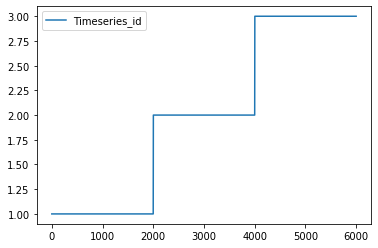

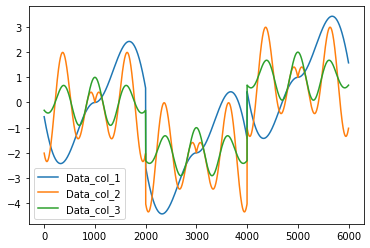

In [23]:
# Generating data and labels
def dummy_function(x):
    timeseries_nbr = 1
    a = 0.4 * np.sin(0.3 * x) * np.abs(x)
    b = np.log1p(np.abs(x)) * np.cos(x)
    c = np.exp(-x**2 / 100) * np.cos(x)
    return [timeseries_nbr, a, b, c]

x = np.arange(-10, 10, 0.01)

df1 = pd.DataFrame(np.array([dummy_function(xi) for xi in x]),
                  columns=['Timeseries_id', 'Data_col_1', 'Data_col_2', 'Data_col_3'])

df2 = pd.DataFrame(np.array([dummy_function(xi) for xi in x]),
                  columns=['Timeseries_id', 'Data_col_1', 'Data_col_2', 'Data_col_3'])
df2 = df2 - 2
df2['Timeseries_id'] = 2

df3 = pd.DataFrame(np.array([dummy_function(xi) for xi in x]),
                  columns=['Timeseries_id', 'Data_col_1', 'Data_col_2', 'Data_col_3'])
df3 = df3 + 1
df3['Timeseries_id'] = 3

df = pd.concat([df1, df2, df3]).reset_index().drop(columns='index')

COLUMN_NBR = df.shape[1] - 1 # timeseries id is not data column

df[['Timeseries_id']].plot()
df[['Data_col_1', 'Data_col_2', 'Data_col_3']].plot()

In [24]:
df.head()

,Timeseries_id,Data_col_1,Data_col_2,Data_col_3
0,1.0,-0.564480,-2.012006,-0.308677
1,1.0,-0.575781,-2.024182,-0.311285
2,1.0,-0.587053,-2.036145,-0.313870
3,1.0,-0.598296,-2.047895,-0.316431
4,1.0,-0.609510,-2.059429,-0.318970


In [25]:
# Rolling window generalized
# Create timeseries dataset
timeseries = tf.data.Dataset.from_tensor_slices(df[['Timeseries_id', 'Data_col_1', 'Data_col_2', 'Data_col_3']].values)

# Create dataset of windows out of timeseries dataset
input_feature_steps = 3
predict_steps = 1
stride = 2
shift = 3
window_size = input_feature_steps + predict_steps
windows = timeseries.window(size=window_size,
                             shift=shift,
                             stride=stride)

# Batchify then flatten the dataset of batches into a dataset of their elements
windows = windows.flat_map(lambda x: x.batch(window_size, drop_remainder=True))

print('Rolling window:')
for i, example in enumerate(windows.take(3)):
    print('window', i, ':\n', example.numpy())

# Split rolling window into input features and labels(predicted features)
features = df.shape[1] - 1 # timeseries id is not a feature
ifd = tf.zeros((input_feature_steps, features), dtype=tf.float64, name='input_feature_dummy')
psd = tf.zeros((predict_steps, features), dtype=tf.float64, name='predict_steps_dummy')
def split_at_n(batch, n):
    # Expect the first column to be the timeseries id
    
    # Check if timeseries ids in the tensor equals the first id
    is_different = tf.math.not_equal(batch[:, 0], batch[0, 0])
    if tf.math.count_nonzero(is_different) == 0:
        # All timeseries id is the same, return data
        return batch[:-n, 1:], batch[-n:, 1:]
    else:
        # At least one timeseries id is different, return zero tensors
        return ifd, psd
inputs_and_labels = windows.map(lambda x: split_at_n(x, n=predict_steps))

# Drop windows which were set to zero (not enough data at the end of the timeseries)
def filter_fn(x, y):
    # Evaluate elementwise: x[i] != 0 (0 -> False, anything else -> True)
    x_is_zero = tf.math.not_equal(x, ifd)
    y_is_zero = tf.math.not_equal(y, psd)
    
    # Count elements in tensor which are True(non-zero)
    x_nonzero = tf.math.count_nonzero(x_is_zero)
    y_nonzero = tf.math.count_nonzero(y_is_zero)
    
    # If any element in x or y is non-zero then keep it
    return (x_nonzero + y_nonzero) > 0
inputs_and_labels = inputs_and_labels.filter(filter_fn)

# .prefetch(x) for faster pipeline

print()
print('Split rolling window into input features and labels(predicted features):')
for input_feature, label in inputs_and_labels.take(3):
    print(input_feature.numpy(), "=>", label.numpy())
    
# Make batches and shuffle before feeding the neural network
inputs_and_labels = inputs_and_labels.batch(32)
inputs_and_labels = inputs_and_labels.shuffle(buffer_size=100)

Rolling window:
window 0 :
 [[ 1.         -0.56448003 -2.01200565 -0.30867717]
 [ 1.         -0.58705309 -2.03614517 -0.31386957]
 [ 1.         -0.60951006 -2.05942904 -0.31897001]
 [ 1.         -0.63185021 -2.08184907 -0.32397551]]
window 1 :
 [[ 1.         -0.59829613 -2.04789458 -0.31643147]
 [ 1.         -0.62069478 -2.07074753 -0.32148481]
 [ 1.         -0.64297626 -2.09273269 -0.32644174]
 [ 1.         -0.66513987 -2.11384243 -0.33129932]]
window 2 :
 [[ 1.         -0.63185021 -2.08184907 -0.32397551]
 [ 1.         -0.65407284 -2.10339745 -0.32888313]
 [ 1.         -0.67617724 -2.12406674 -0.33368994]
 [ 1.         -0.69816271 -2.14384986 -0.33839303]]

Split rolling window into input features and labels(predicted features):
[[-0.56448003 -2.01200565 -0.30867717]
 [-0.58705309 -2.03614517 -0.31386957]
 [-0.60951006 -2.05942904 -0.31897001]] => [[-0.63185021 -2.08184907 -0.32397551]]
[[-0.59829613 -2.04789458 -0.31643147]
 [-0.62069478 -2.07074753 -0.32148481]
 [-0.64297626 -2.092

In [26]:
model = create_model()
model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 3, 3)]            0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 9)                 0         
_________________________________________________________________
1st (Dense)                  (None, 128)               1280      
_________________________________________________________________
2nd (Dense)                  (None, 32)                4128      
_________________________________________________________________
3rd (Dense)                  (None, 3)                 99        
_________________________________________________________________
reshape_1 (Reshape)          (None, 1, 3)              0         
Total params: 5,507
Trainable params: 5,507
Non-trainable params: 0
_________________________________________________________

In [27]:
model.fit(inputs_and_labels, epochs=10, verbose=1)

Epoch 1/10
63/63 [==============================] - 1s 21ms/step - loss: 1.2550
Epoch 2/10
63/63 [==============================] - 1s 9ms/step - loss: 0.1361
Epoch 3/10
63/63 [==============================] - 1s 10ms/step - loss: 0.0322
Epoch 4/10
63/63 [==============================] - 0s 8ms/step - loss: 0.0164
Epoch 5/10
63/63 [==============================] - 1s 9ms/step - loss: 0.0097
Epoch 6/10
63/63 [==============================] - 1s 8ms/step - loss: 0.0069
Epoch 7/10
63/63 [==============================] - 1s 9ms/step - loss: 0.0067
Epoch 8/10
63/63 [==============================] - 0s 8ms/step - loss: 0.0068
Epoch 9/10
63/63 [==============================] - 0s 8ms/step - loss: 0.0048
Epoch 10/10
63/63 [==============================] - 1s 10ms/step - loss: 0.0053


In [28]:
# Siamese network (creating all pair combination)

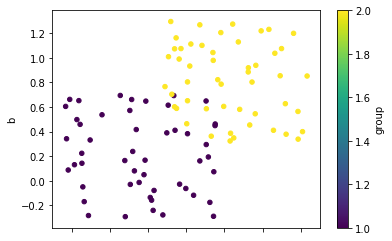

In [29]:
# Generate data
datapoint_nbr = 50
dummy_data_1 = np.random.randint(1000, size=(datapoint_nbr, 3)) / 1000 - 0.3
dummy_data_1[:,2] = 1
dummy_data_2 = np.random.randint(1000, size=(datapoint_nbr, 3)) / 1000 + 0.3
dummy_data_2[:,2] = 2
dummy_data = np.concatenate((dummy_data_1, dummy_data_2))

# Get data shape
data_shape = dummy_data_1[0,:2].shape

# Visualization
df = pd.DataFrame(dummy_data, columns=['a', 'b', 'group'])
df.plot.scatter(x='a', y='b', c='group', colormap='viridis')

In [30]:
# Generate data id pairs (id = index in this case but can be anything unique)
id_list = np.arange(len(dummy_data))

id_pair_list = list(combinations(id_list, 2))
print('Total number of data pairs:', len(id_pair_list))
print()
print(id_pair_list)

# 
id0_list = [x[0] for x in id_pair_list]
id1_list = [x[1] for x in id_pair_list]

Total number of data pairs: 4950

[(0, 1), (0, 2), (0, 3), (0, 4), (0, 5), (0, 6), (0, 7), (0, 8), (0, 9), (0, 10), (0, 11), (0, 12), (0, 13), (0, 14), (0, 15), (0, 16), (0, 17), (0, 18), (0, 19), (0, 20), (0, 21), (0, 22), (0, 23), (0, 24), (0, 25), (0, 26), (0, 27), (0, 28), (0, 29), (0, 30), (0, 31), (0, 32), (0, 33), (0, 34), (0, 35), (0, 36), (0, 37), (0, 38), (0, 39), (0, 40), (0, 41), (0, 42), (0, 43), (0, 44), (0, 45), (0, 46), (0, 47), (0, 48), (0, 49), (0, 50), (0, 51), (0, 52), (0, 53), (0, 54), (0, 55), (0, 56), (0, 57), (0, 58), (0, 59), (0, 60), (0, 61), (0, 62), (0, 63), (0, 64), (0, 65), (0, 66), (0, 67), (0, 68), (0, 69), (0, 70), (0, 71), (0, 72), (0, 73), (0, 74), (0, 75), (0, 76), (0, 77), (0, 78), (0, 79), (0, 80), (0, 81), (0, 82), (0, 83), (0, 84), (0, 85), (0, 86), (0, 87), (0, 88), (0, 89), (0, 90), (0, 91), (0, 92), (0, 93), (0, 94), (0, 95), (0, 96), (0, 97), (0, 98), (0, 99), (1, 2), (1, 3), (1, 4), (1, 5), (1, 6), (1, 7), (1, 8), (1, 9), (1, 10), (1, 11), (

In [31]:
# Create datasets from IDs
dataset0 = tf.data.Dataset.from_tensor_slices(id0_list)
dataset1 = tf.data.Dataset.from_tensor_slices(id1_list)
label = tf.data.Dataset.from_tensor_slices(id_pair_list)

In [32]:
# Load data
def id_to_data(ID):  
    # Get data except label (last column)
    data = dummy_data[ID][:-1]
    
    return data

def get_data(ID):
    # This function is basically a wrapper for numpy-tensor conversion
    [X, ] = tf.py_function(id_to_data, [ID], [tf.float32])
    
    # https://github.com/tensorflow/tensorflow/issues/24520
    X.set_shape(data_shape)
    
    return X

dataset0 = dataset0.map(get_data, num_parallel_calls=None)
dataset1 = dataset1.map(get_data, num_parallel_calls=None)
dataset = tf.data.Dataset.zip((dataset0, dataset1))

In [33]:
# Load labels
def id_to_label(ID_pair):  
    # Get label (last column)
    a = dummy_data[ID_pair[0]][-1]
    b = dummy_data[ID_pair[1]][-1]
    label = int(a == b)
    
    return [label]

def get_label(ID_pair):
    # This function is basically a wrapper for numpy-tensor conversion
    [y, ] = tf.py_function(id_to_label, [ID_pair], [tf.float32])
    
    # https://github.com/tensorflow/tensorflow/issues/24520
    y.set_shape([])
    
    return y

label = label.map(get_label, num_parallel_calls=None)

In [34]:
# Merge data and label
inputs_and_labels = tf.data.Dataset.zip((dataset, label))

for (x0,x1),y in inputs_and_labels.take(3):
    print('Inputs:', x0.numpy(), ' , ', x1.numpy())
    print('Labels:', y.numpy())
    print()

Inputs: [ 0.496 -0.063]  ,  [-0.187  0.142]
Labels: 1.0

Inputs: [ 0.496 -0.063]  ,  [0.688 0.448]
Labels: 1.0

Inputs: [ 0.496 -0.063]  ,  [0.425 0.41 ]
Labels: 1.0



In [35]:
# Prepare for training
inputs_and_labels = inputs_and_labels.batch(32)
inputs_and_labels = inputs_and_labels.shuffle(buffer_size=100)

In [36]:
# Siamese model
def euclidean_distance(vects):
    # L2 distance
    x, y = vects
    sum_square = K.sum(K.square(x - y), axis=1, keepdims=True)
    ecd = K.sqrt(K.maximum(sum_square, K.epsilon()))
    return ecd

def create_model(data_shape, drop_rate=0.0, activation='relu', loss='mse', optimizer='adam'): 
    input0 = Input(shape=data_shape, name='data')
    
    dense0 = Dense(6, activation=None, name='1st_dense') (input0)
    act0 = Activation(activation, name='1st_activation') (dense0)
  
    dense1 = Dense(3, activation=None, name='last_dense') (act0)
    act1 = Activation(activation, name='shared_output') (dense1)
  
    shared_model = Model(inputs=input0, outputs=act1, name='shared_model')
    shared_model.summary()
  
    ##############
  
    input_siam_a = Input(shape=data_shape, name='input_siam_a')
    input_siam_b = Input(shape=data_shape, name='input_siam_b')
  
    model_a = shared_model(input_siam_a)
    model_b = shared_model(input_siam_b)

    dist_layer = Lambda(euclidean_distance, name='distance_layer') ([model_a, model_b])
  
    model = Model(inputs=[input_siam_a, input_siam_b], outputs=dist_layer)
  
    model.compile(loss=loss, optimizer=optimizer)
  
    return model

# Create model
model = create_model(data_shape=(2,),
                     drop_rate=0,
                     activation='relu',
                     loss=tfa.losses.ContrastiveLoss(margin=1),
                     optimizer='adam')
model.summary()

Model: "shared_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
data (InputLayer)            [(None, 2)]               0         
_________________________________________________________________
1st_dense (Dense)            (None, 6)                 18        
_________________________________________________________________
1st_activation (Activation)  (None, 6)                 0         
_________________________________________________________________
last_dense (Dense)           (None, 3)                 21        
_________________________________________________________________
shared_output (Activation)   (None, 3)                 0         
Total params: 39
Trainable params: 39
Non-trainable params: 0
_________________________________________________________________
Model: "model_2"
__________________________________________________________________________________________________
Layer (t

In [37]:
model.fit(inputs_and_labels, epochs=3, verbose=1)

Train for 155 steps
Epoch 1/3
155/155 [==============================] - 4s 23ms/step - loss: 0.1915
Epoch 2/3
155/155 [==============================] - 3s 22ms/step - loss: 0.1495
Epoch 3/3
155/155 [==============================] - 6s 40ms/step - loss: 0.1372
